### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
import pandas as pd

In [84]:
%run CrossSectionFunctions.ipynb


particle_mass = {
    'Proton': 1e-6,
    'Neutron': 1e-5,
    'Lambda': 1e-6,
    'ChargedPion': 1e-7,
    'NeutralPion': 10,
    'ChargedKaon': 0.5e-8,
    'NeutralKaon': 1e-8,
}

particle_cross_sections = {
    'Proton': 0.5e-7,
    'Neutron': 1e-7,
    'Lambda': 1e-9,
    'ChargedPion': 0.5e-5,
    'NeutralPion': 1e-5,
    'ChargedKaon': 0.5e-6,
    'NeutralKaon': 1e-6,
}


particle_ratios = {
    particle: particle_mass[particle] / particle_mass["Lambda"]
    for particle in particle_mass
}

linestyles = {
    "Proton": "-", 
    "Neutron": "--", 
    "Lambda": "-.", 
    "ChargedPion": ":", 
    "NeutralPion": (0, (3, 1, 1, 1)),  # Custom dash pattern
    "ChargedKaon": (0, (5, 2)), 
    "NeutralKaon": (0, (1, 1))
}


C:\Users\press\AppData\Local\Temp\ipykernel_24400\2044238584.py:15: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_result, error = quad(integrand, 4 * mass**2, np.inf)


Σm_i*Y_i = 0.006647531053987828 GeV


Text(0.02, 0.02, 'Σm_i*Y_i = 6.65e-03 GeV')

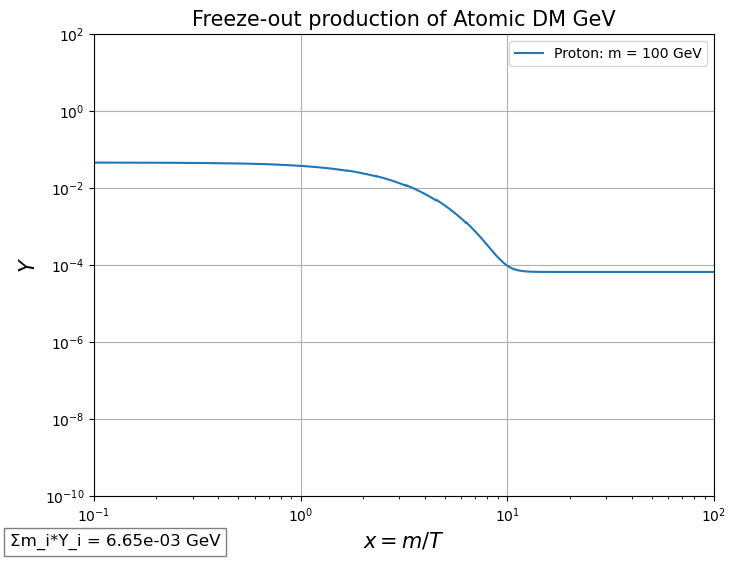

In [86]:
%run FreezeOutFunctions.ipynb
#%run CrossSectionFunctions.ipynb

particle_mass = {
    'Proton': 100,
    'NeutralPion': 1,
}

particle_coupling_constants = {
    'NeutralPion': 1e-1,
}

particles = ['Proton']#["Proton", "Neutron", "Lambda", "ChargedPion", "NeutralPion", "ChargedKaon", "NeutralKaon"]

xmax = 1e2

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8, 6))

x=np.logspace(np.log10(0.1),np.log10(xmax),10000)

FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    #cross_section = particle_cross_sections.get(particle,1)
    mass = particle_mass.get(particle,1)
    
    Y=integrate.odeint(dYdx,Y_EQ(x[0], particle), x, args=(particle,))
    Decay_rate = AvgDecayRate(x)
    Y_New = Y.reshape(1,-1)
    
    if particle in ("Lambda", "NeutralKaon", "ChargedKaon"):
        Y_Decayed = np.multiply(Y_New,Decay_rate)
        Y_Decayed_New = Y_Decayed.reshape(-1,1)
        FreezeOutNumber = np.append(FreezeOutNumber,Y_Decayed_New[-1])
        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_Decayed_New[-1]}')
        plt.loglog(x, Y_Decayed_New, label=f'{particle} σv = {cross_section}, m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        
    else:
        plt.loglog(x, Y, label=f'{particle}: m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        FreezeOutNumber = np.append(FreezeOutNumber,Y[-1])

        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y[-1]}')
    
    masses = np.append(masses, mass)

#print('Frozen-out values: ', FreezeOutNumber)
#print(f'Particle masses: {masses}')
#print('mult', np.multiply(masses,FreezeOutNumber))
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.ylim(1e-10,1e2)
plt.xlim(1e-1,xmax)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Atomic DM GeV', size= 15)
plt.legend()
plt.grid()
plt.gcf().text(0.02, 0.02, f"Σm_i*Y_i = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.savefig('Particles.png', facecolor = 'w')

Text(2.3, 1000.0, 'Vacuum Energy dominated universe')

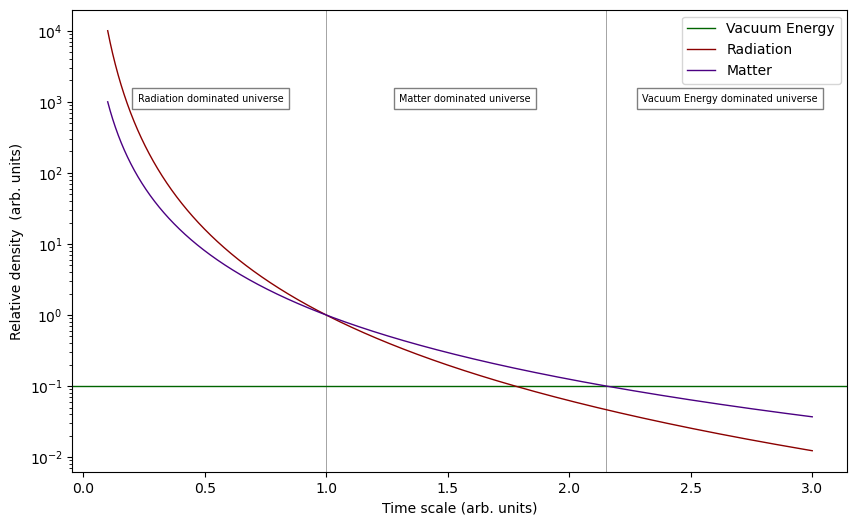

In [5]:
def lightdom(x):
    return x**(-4)

def matterdom(x):
    return x**(-3)

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 6))

T_ex = np.linspace(0.1, 3, num = 10000)

Y_lightdom = lightdom(T_ex)
Y_matterdom = matterdom(T_ex)

plt.axvline(1, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axvline(2.15, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axhline(1e-1, linewidth = 1, color = 'darkgreen', label = 'Vacuum Energy')
plt.plot(T_ex,Y_lightdom, label = 'Radiation', color = 'darkred',linewidth = 1)
plt.plot(T_ex, Y_matterdom, label = 'Matter', color = 'indigo', linewidth = 1)
plt.legend()
plt.xlabel('Time scale (arb. units)')
plt.ylabel('Relative density  (arb. units)')
plt.yscale('log')
plt.text(1.3,1e3,"Matter dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(0.225,1e3,"Radiation dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(2.3,1e3,"Vacuum Energy dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')

#plt.grid(linestyle = '--')
#plt.ylim(0,3)
#plt.savefig('TimeScaleArb.png')

In [6]:
print(thermally_averaged_cross_section(10, "Proton"))

2.1300065746218178e-16


In [7]:
"""
particle_ratios = {
    "ChargedPion": R_CP,
    "ChargedKaon": R_CK,
    "NeutralPion": R_NP,
    "NeutralKaon": R_NK,
    "Lambda": R_L,
    "Proton": R_P,
    "Neutron": R_N,
    "TestMeson": R_testMeson,
    "TestBaryon": R_testBaryon
}

particle_mass = {
    'Proton': 1e-5,
    'Neutron': 1e-5,
    'Lambda': 1e-3,
    'ChargedPion': 1e-7,
    'NeutralPion': 1e-7,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 1e-6,
    'TestBaryon': 1e-5,
    'TestMeson': 1e-5,
}

particle_cross_sections = {
    'Proton': 1e-8,
    'Neutron': 1e-8,
    'Lambda': 1e-9,
    'ChargedPion': 1e-10,
    'NeutralPion': 1e-10,
    'ChargedKaon': 1e-10,
    'NeutralKaon': 1e-10,
    "TestMeson": 1e-7
}

particle_mass = {
    'Proton': 1e-10,
    'Neutron': 1e-10,
    'Lambda': 1e-9,
    'ChargedPion': 1e-11,
    'NeutralPion': 1e-11,
    'ChargedKaon': 0.5e-10,
    'NeutralKaon': 0.5e-10,
}

particle_cross_sections = {
    'Proton': 1e-6,
    'Neutron': 1e-6,
    'Lambda': 1e-9,
    'ChargedPion': 1e-5,
    'NeutralPion': 1e-6,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 1e-7,
}


particle_mass = {
    'Proton': 1e-5,
    'Neutron': 5e-4,
    'Lambda': 5e-4,
    'ChargedPion': 1e-8,
    'NeutralPion': 5e-9,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 5e-6,
    'TestBaryon': 1e-5,
    'TestMeson': 1e-5,
}

particle_cross_sections = {
    'Proton': 1e-8,
    'Neutron': 1e-8,
    'Lambda': 1e-7,
    'ChargedPion': 1e-13,
    'NeutralPion': 1e-13,
    'ChargedKaon': 1e-10,
    'NeutralKaon': 1e-10,
    "TestMeson": 1e-7
}


##this one works for decaying particles
particle_mass = {
    'Proton': 1e-6,
    'Neutron': 1e-5,
    'Lambda': 1e-6,
    'ChargedPion': 1e-7,
    'NeutralPion': 1e-6,
    'ChargedKaon': 0.5e-8,
    'NeutralKaon': 1e-8,
}

particle_cross_sections = {
    'Proton': 0.5e-7,
    'Neutron': 1e-7,
    'Lambda': 1e-9,
    'ChargedPion': 0.5e-5,
    'NeutralPion': 1e-5,
    'ChargedKaon': 0.5e-6,
    'NeutralKaon': 1e-6,
}


# PARTICLE RATIOS TO SCALE THE X VALUES. EVERYTHING IS SCALED BASED OFF THE NEUTRAL PION AS IT IS THE LIGHTEST HADRON
R_NP = particle_mass.get("NeutralPion")/particle_mass.get("Lambda")
R_CP = particle_mass.get("ChargedPion")/particle_mass.get("Lambda")
R_NK = particle_mass.get("NeutralKaon")/particle_mass.get("Lambda")
R_CK = particle_mass.get("ChargedKaon")/particle_mass.get("Lambda")
R_L = 1
R_P = particle_mass.get("Proton")/particle_mass.get("Lambda")
R_N = particle_mass.get("Neutron")/particle_mass.get("Lambda")

particle_ratios = {
    "ChargedPion": R_CP,
    "ChargedKaon": R_CK,
    "NeutralPion": R_NP,
    "NeutralKaon": R_NK,
    "Lambda": R_L,
    "Proton": R_P,
    "Neutron": R_N,
}
"""

'\nparticle_ratios = {\n    "ChargedPion": R_CP,\n    "ChargedKaon": R_CK,\n    "NeutralPion": R_NP,\n    "NeutralKaon": R_NK,\n    "Lambda": R_L,\n    "Proton": R_P,\n    "Neutron": R_N,\n    "TestMeson": R_testMeson,\n    "TestBaryon": R_testBaryon\n}\n\nparticle_mass = {\n    \'Proton\': 1e-5,\n    \'Neutron\': 1e-5,\n    \'Lambda\': 1e-3,\n    \'ChargedPion\': 1e-7,\n    \'NeutralPion\': 1e-7,\n    \'ChargedKaon\': 1e-6,\n    \'NeutralKaon\': 1e-6,\n    \'TestBaryon\': 1e-5,\n    \'TestMeson\': 1e-5,\n}\n\nparticle_cross_sections = {\n    \'Proton\': 1e-8,\n    \'Neutron\': 1e-8,\n    \'Lambda\': 1e-9,\n    \'ChargedPion\': 1e-10,\n    \'NeutralPion\': 1e-10,\n    \'ChargedKaon\': 1e-10,\n    \'NeutralKaon\': 1e-10,\n    "TestMeson": 1e-7\n}\n\nparticle_mass = {\n    \'Proton\': 1e-10,\n    \'Neutron\': 1e-10,\n    \'Lambda\': 1e-9,\n    \'ChargedPion\': 1e-11,\n    \'NeutralPion\': 1e-11,\n    \'ChargedKaon\': 0.5e-10,\n    \'NeutralKaon\': 0.5e-10,\n}\n\nparticle_cross_sections =

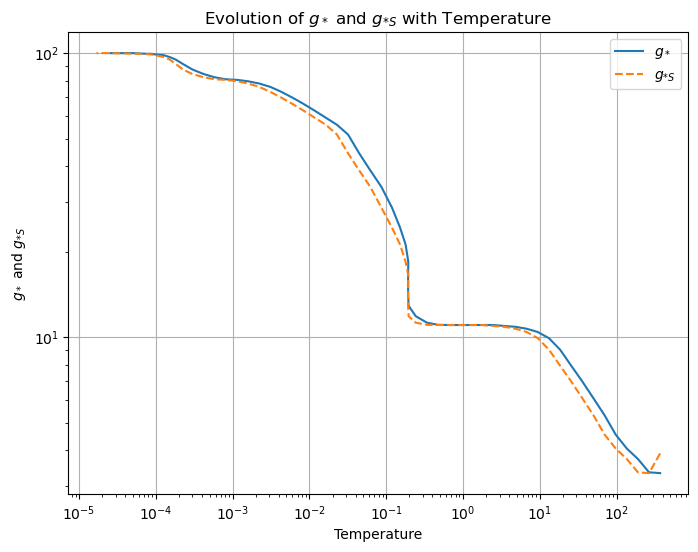

In [8]:
# Load the data
Gstar_df = pd.read_csv("Gstar.csv", header = None)
GstarS_df = pd.read_csv("GstarS.csv", header = None)

# Convert to dictionaries while preserving order
Gstar = dict(zip(Gstar_df.iloc[:, 0], Gstar_df.iloc[:, 1]))
GstarS = dict(zip(GstarS_df.iloc[:, 0], GstarS_df.iloc[:, 1]))


# Extract temperature values and corresponding function values in original order
temps_Gstar = Gstar_df.iloc[:, 0].values  # Keep order from CSV
values_Gstar = np.flip(Gstar_df.iloc[:, 1].values)  

temps_GstarS = GstarS_df.iloc[:, 0].values  # Keep order from CSV
values_GstarS = np.flip(GstarS_df.iloc[:, 1].values)  

# Plot the functions
plt.figure(figsize=(8, 6))
plt.plot(temps_Gstar, values_Gstar, label="$g_*$", linestyle="-")
plt.plot(temps_GstarS, values_GstarS, label="$g_{*S}$", linestyle="--")
plt.xscale('log')

plt.yscale('log')

# Labels and title
plt.xlabel("Temperature")
plt.ylabel("$g_*$ and $g_{*S}$")
plt.title("Evolution of $g_*$ and $g_{*S}$ with Temperature")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [9]:
"""
Y0 = [1e5]  
x_min = 1e-5 
x_max = 100
x_span = (x_min, x_max)
x_eval = np.geomspace(x_min, x_max, 5000)

# THE STRING ENCLOSED WITHIN THE "" IS TELLING THE CODE WHAT RATIO TO USE REGARDLESS OF WHAT VARIABLE YOU PASS THROUGH NEXT
sigma_values = {
    "TestMeson": Sigma_Meson,
    #"TestBaryon": Sigma_Baryon
}

for particle, sigma_value in sigma_values.items():
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), x_span, Y0, t_eval=x_eval)
    print(particle)

    sol_Y0 = solve_ivp(lambda x, Y: dYdx(1, Y, particle), x_span, Y0, dense_output=True)
    y0 = lambda Y: sol_Y0.sol(Y)[0]
    print(f'y(0) = {y0(0)}')    

    # Number of frozen-out DM particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    print(f'Cross section of {particle} = {sigma_value}')
    
    plt.plot(sol.t, sol.y[0]/y0(0), label=f'{particle}')
    
# Plot configurations
plt.yscale('log')  
plt.xscale('log')  
plt.xlabel('log(x = m/T)')
plt.ylabel('log(Y/Y(x=0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()
"""

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_24400\1272176787.py:1: SyntaxWarning: invalid escape sequence '\s'
  """


'\nY0 = [1e5]  \nx_min = 1e-5 \nx_max = 100\nx_span = (x_min, x_max)\nx_eval = np.geomspace(x_min, x_max, 5000)\n\n# THE STRING ENCLOSED WITHIN THE "" IS TELLING THE CODE WHAT RATIO TO USE REGARDLESS OF WHAT VARIABLE YOU PASS THROUGH NEXT\nsigma_values = {\n    "TestMeson": Sigma_Meson,\n    #"TestBaryon": Sigma_Baryon\n}\n\nfor particle, sigma_value in sigma_values.items():\n    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), x_span, Y0, t_eval=x_eval)\n    print(particle)\n\n    sol_Y0 = solve_ivp(lambda x, Y: dYdx(1, Y, particle), x_span, Y0, dense_output=True)\n    y0 = lambda Y: sol_Y0.sol(Y)[0]\n    print(f\'y(0) = {y0(0)}\')    \n\n    # Number of frozen-out DM particles\n    Y_frozen = sol.y[0, -1]\n    print(f\'Frozen-out Y(x) for {particle} = {Y_frozen}\')\n    print(f\'Cross section of {particle} = {sigma_value}\')\n    \n    plt.plot(sol.t, sol.y[0]/y0(0), label=f\'{particle}\')\n    \n# Plot configurations\nplt.yscale(\'log\')  \nplt.xscale(\'log\')  \nplt.xlabel(\'log(

In [10]:
"""
%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

#Y0 = [10]  
x_min = 1e-2 
x_max = 100
x_span = (x_min, x_max)
x_eval = np.geomspace(x_min, x_max, 5000)
xx=np.logspace(np.log10(1.1),np.log10(1e100),1000)
xx = np.log10(xx)

sigma_values = ["TestMeson"]#, "TestBaryon", "TestMeson2", "TestMeson3", "TestMeson4", "TestMeson5"]


for particle in sigma_values:
    Y0 = [YInitial(particle)]
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), (np.log10(1.1),np.log10(1e100)), Y0, t_eval=xx)

    sol_Y0 = solve_ivp(lambda x, Y: dYdx(1, Y, particle), x_span, Y0, dense_output=True)
    y0 = lambda Y: sol_Y0.sol(Y)[0]
    #print(f'y(0) = {y0(0)}')
    
    # Number of frozen-out DM particles
    #print(sol.y)
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    
    plt.loglog(sol.t, sol.y[0], label=f'{particle}')

Y = Y_EQ(xx, "TestMeson")
plt.loglog(xx, Y, label="Y_EQ")

# Plot configurations
#plt.yscale('log')  
#plt.xscale('log')  
plt.xlabel('log(x = m/T)')
plt.ylabel('log(Y/Y(0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.ylim(1e-15, 15)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()
"""

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_24400\1387729828.py:1: SyntaxWarning: invalid escape sequence '\s'
  """


'\n%run FreezeOutFunctions.ipynb\n%run CrossSectionFunctions.ipynb\n\n#Y0 = [10]  \nx_min = 1e-2 \nx_max = 100\nx_span = (x_min, x_max)\nx_eval = np.geomspace(x_min, x_max, 5000)\nxx=np.logspace(np.log10(1.1),np.log10(1e100),1000)\nxx = np.log10(xx)\n\nsigma_values = ["TestMeson"]#, "TestBaryon", "TestMeson2", "TestMeson3", "TestMeson4", "TestMeson5"]\n\n\nfor particle in sigma_values:\n    Y0 = [YInitial(particle)]\n    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), (np.log10(1.1),np.log10(1e100)), Y0, t_eval=xx)\n\n    sol_Y0 = solve_ivp(lambda x, Y: dYdx(1, Y, particle), x_span, Y0, dense_output=True)\n    y0 = lambda Y: sol_Y0.sol(Y)[0]\n    #print(f\'y(0) = {y0(0)}\')\n    \n    # Number of frozen-out DM particles\n    #print(sol.y)\n    Y_frozen = sol.y[0, -1]\n    print(f\'Frozen-out Y(x) for {particle} = {Y_frozen}\')\n    \n    plt.loglog(sol.t, sol.y[0], label=f\'{particle}\')\n\nY = Y_EQ(xx, "TestMeson")\nplt.loglog(xx, Y, label="Y_EQ")\n\n# Plot configurations\n#plt.ysc

In [11]:
"""
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint

Mp = M_Pl

def fk(particle):
    mass = particle_mass.get(particle,1)
    cross_section = particle_cross_sections.get(particle,1)
    return np.sqrt(np.pi*Mp**2/45)*mass*cross_section

def Y_EQ(x, particle):
    mass = particle_mass.get(particle, 1)
    return n_eq(x, particle) / s(x, particle)

def BEx(x, particle):
    mass = particle_mass.get(particle,1)
    T=mass/x

    return k*g_star(T)/x**2

def BE(Y,x,particle):
    return -(Y**2-Y_EQ(x, particle)**2)*BEx(x, particle)
"""

'\nfrom scipy import optimize\nfrom scipy import integrate\nfrom scipy.integrate import odeint\n\nMp = M_Pl\n\ndef fk(particle):\n    mass = particle_mass.get(particle,1)\n    cross_section = particle_cross_sections.get(particle,1)\n    return np.sqrt(np.pi*Mp**2/45)*mass*cross_section\n\ndef Y_EQ(x, particle):\n    mass = particle_mass.get(particle, 1)\n    return n_eq(x, particle) / s(x, particle)\n\ndef BEx(x, particle):\n    mass = particle_mass.get(particle,1)\n    T=mass/x\n\n    return k*g_star(T)/x**2\n\ndef BE(Y,x,particle):\n    return -(Y**2-Y_EQ(x, particle)**2)*BEx(x, particle)\n'

In [12]:
"""
%run CrossSectionFunctions.ipynb

xx=np.logspace(np.log10(1),np.log10(1000),1000)
plt.loglog(xx,Y_EQ(xx, particle),'c',label=r'$Y_{\rm eq}$')

k=fk("TestMeson")
x=np.logspace(np.log10(1),np.log10(1000),10000)
Y=integrate.odeint(BE,Y_EQ(x[0], particle),x, args=(particle,))
plt.loglog(x,Y,'r--',label=r'$\langle \sigma v \rangle = 10^{-18}\ {\rm GeV}^{-2}$')


plt.ylim(1E-14,1)
plt.xlim(1,1000)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('$m = 100$ GeV', size= 15)
plt.legend()
plt.grid()
"""

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\press\AppData\Local\Temp\ipykernel_24400\3206298348.py:1: SyntaxWarning: invalid escape sequence '\l'
  """


'\n%run CrossSectionFunctions.ipynb\n\nxx=np.logspace(np.log10(1),np.log10(1000),1000)\nplt.loglog(xx,Y_EQ(xx, particle),\'c\',label=r\'$Y_{\rm eq}$\')\n\nk=fk("TestMeson")\nx=np.logspace(np.log10(1),np.log10(1000),10000)\nY=integrate.odeint(BE,Y_EQ(x[0], particle),x, args=(particle,))\nplt.loglog(x,Y,\'r--\',label=r\'$\\langle \\sigma v \rangle = 10^{-18}\\ {\rm GeV}^{-2}$\')\n\n\nplt.ylim(1E-14,1)\nplt.xlim(1,1000)\nplt.xlabel(\'$x = m/T$\', size= 15)\nplt.ylabel(\'$Y$\', size= 15)\nplt.title(\'$m = 100$ GeV\', size= 15)\nplt.legend()\nplt.grid()\n'

Frozen-out value of Proton with sigma = 1e-14, and mass = 100 GeV is [5.59623664e-08]
Frozen-out value of Neutron with sigma = 1e-15, and mass = 100 GeV is [5.0204965e-07]
Frozen-out value of Lambda with sigma = 1e-16, and mass = 100 GeV is [4.11300628e-06]
Frozen-out value of ChargedPion with sigma = 1e-17, and mass = 100 GeV is [3.20291551e-05]
Frozen-out value of NeutralPion with sigma = 1e-18, and mass = 100 GeV is [0.00023223]
Frozen-out values:  [5.59623664e-08 5.02049650e-07 4.11300628e-06 3.20291551e-05
 2.32234900e-04]
Particle masses: [100. 100. 100. 100. 100.]
Σm_i*Y_i = 0.02689350736634106 GeV


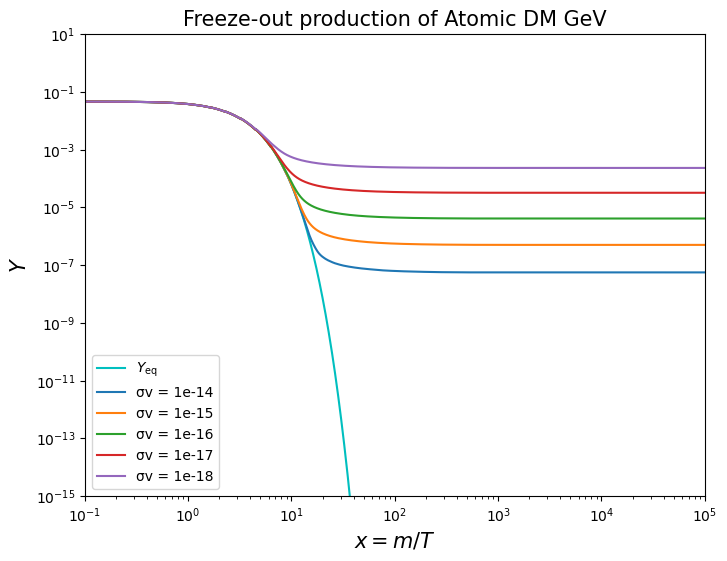

In [129]:
"""
%run CrossSectionFunctions.ipynb

# Cross-section formula for a single Lambda
def sigma(s, particle):
    #cross_section = particle_cross_sections.get(particle, 1)
    k = particle_coupling_constants.get(particle,1)
    return k/(2*s)
    #return sum(Lambda / (2 * s) for Lambda in lambdas) #Make an array that has lambdas_pion, lambdas_proton, lambdas_neutron, etc. for all of their interactions
    
def thermally_averaged_cross_section(T, particle):
    def integrand(s):
        return sigma(s, particle) * np.sqrt(s) * kn(1, np.sqrt(s) / T)

    mass = particle_mass.get(particle, 1)
    integral_result, error = quad(integrand, 4 * mass**2, np.inf)
    return (1 / (8 * mass**4 * T * kn(2, mass / T))) * integral_result

def fk(particle):
    mass = particle_mass.get(particle,1)
    cross_section = particle_cross_sections.get(particle,1)
    return np.sqrt(np.pi*M_Pl**2/45)*mass*cross_section

def Variables(x, particle):
    mass = particle_mass.get(particle,1)
    T=mass/x
    return k*g_star(T)/x**2

def dYdx(Y,x,particle): # Eqn 7.10 of https://arxiv.org/pdf/1009.3690
    ratio = particle_ratios.get(particle, 1)  

    x_ratio = x*ratio
    #if particle == "Lambda":
        #print(AvgDecayRate(x_ratio))
    #    return -(Y**2-Y_EQ(x_ratio, particle)**2)*Variables(x_ratio, particle)*AvgDecayRate(x_ratio)
    #else:
    return -(Y**2-Y_EQ(x_ratio, particle)**2)*Variables(x_ratio, particle)

particle_mass = {
    'Proton': 100,
    'Neutron': 100,
    'Lambda': 100,
    'ChargedPion': 100,
    'NeutralPion': 100,
    'ChargedKaon': 0.5e-10,
    'NeutralKaon': 0.5e-10,
}

particle_cross_sections = {
    'Proton': 1e-14,
    'Neutron': 1e-15,
    'Lambda': 1e-16,
    'ChargedPion': 1e-17 ,
    'NeutralPion': 1e-18,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 1e-7,
}

# PARTICLE RATIOS TO SCALE THE X VALUES. EVERYTHING IS SCALED BASED OFF THE NEUTRAL PION AS IT IS THE LIGHTEST HADRON
R_NP = particle_mass.get("NeutralPion")/particle_mass.get("Lambda")
R_CP = particle_mass.get("ChargedPion")/particle_mass.get("Lambda")
R_NK = particle_mass.get("NeutralKaon")/particle_mass.get("Lambda")
R_CK = particle_mass.get("ChargedKaon")/particle_mass.get("Lambda")
R_L = 1
R_P = particle_mass.get("Proton")/particle_mass.get("Lambda")
R_N = particle_mass.get("Neutron")/particle_mass.get("Lambda")

particle_ratios = {
    "ChargedPion": R_CP,
    "ChargedKaon": R_CK,
    "NeutralPion": R_NP,
    "NeutralKaon": R_NK,
    "Lambda": R_L,
    "Proton": R_P,
    "Neutron": R_N,
}


particles = ["Proton", "Neutron", "Lambda", "ChargedPion", "NeutralPion"]#, "ChargedKaon", "NeutralKaon"]
plt.figure(figsize=(8, 6))

x=np.logspace(np.log10(0.1),np.log10(100000),10000)
xx=np.logspace(np.log10(0.1),np.log10(1000),10000)
plt.loglog(xx,Y_EQ(xx, 'Proton'),'c',label=r'$Y_{\rm eq}$')

FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    cross_section = particle_cross_sections.get(particle,1)
    mass = particle_mass.get(particle,1)
    
    k=fk(particle)
    Y=integrate.odeint(dYdx,Y_EQ(x[0], particle), x, args=(particle,))
    
    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y[-1]}')
    
    plt.loglog(x,Y,label=f'σv = {cross_section}')
    
    FreezeOutNumber = np.append(FreezeOutNumber,Y[-1])
    masses = np.append(masses, mass)

print('Frozen-out values: ', FreezeOutNumber)
#print(f'Sum of frozen-out values: {np.sum(FreezeOutNumber)}')
print(f'Particle masses: {masses}')
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.ylim(1E-15,10)
plt.xlim(0.1,100000)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Atomic DM GeV', size= 15)
plt.legend()
#plt.grid()
#plt.savefig('Particles.png')
"""

[100.10671073 100.10671073 100.10671073 ...  16.52586597  16.52586597
  16.52586597]
[100.10671073 100.10671073 100.10671073 ...  10.87681056  10.87681056
  10.87681056]
Frozen-out value of Proton with sigma = 1e-14, and mass = 100 GeV is [5.59613975e-08]
[100.10671073 100.10671073 100.10671073 ...  10.87681056  10.87681056
  10.87681056]
Frozen-out value of Neutron with sigma = 1e-15, and mass = 100 GeV is [5.02363607e-07]
[100.10671073 100.10671073 100.10671073 ...  10.87681056  10.87681056
  10.87681056]
Frozen-out value of Lambda with sigma = 1e-16, and mass = 100 GeV is [4.10827224e-06]
[100.10671073 100.10671073 100.10671073 ...  10.87681056  10.87681056
  10.87681056]
Frozen-out value of ChargedPion with sigma = 1e-17, and mass = 100 GeV is [3.20763941e-05]
[100.10671073 100.10671073 100.10671073 ...  10.87681056  10.87681056
  10.87681056]
Frozen-out value of NeutralPion with sigma = 1e-18, and mass = 100 GeV is [0.00023232]
Frozen-out values:  [5.59613975e-08 5.02363607e-07 4.

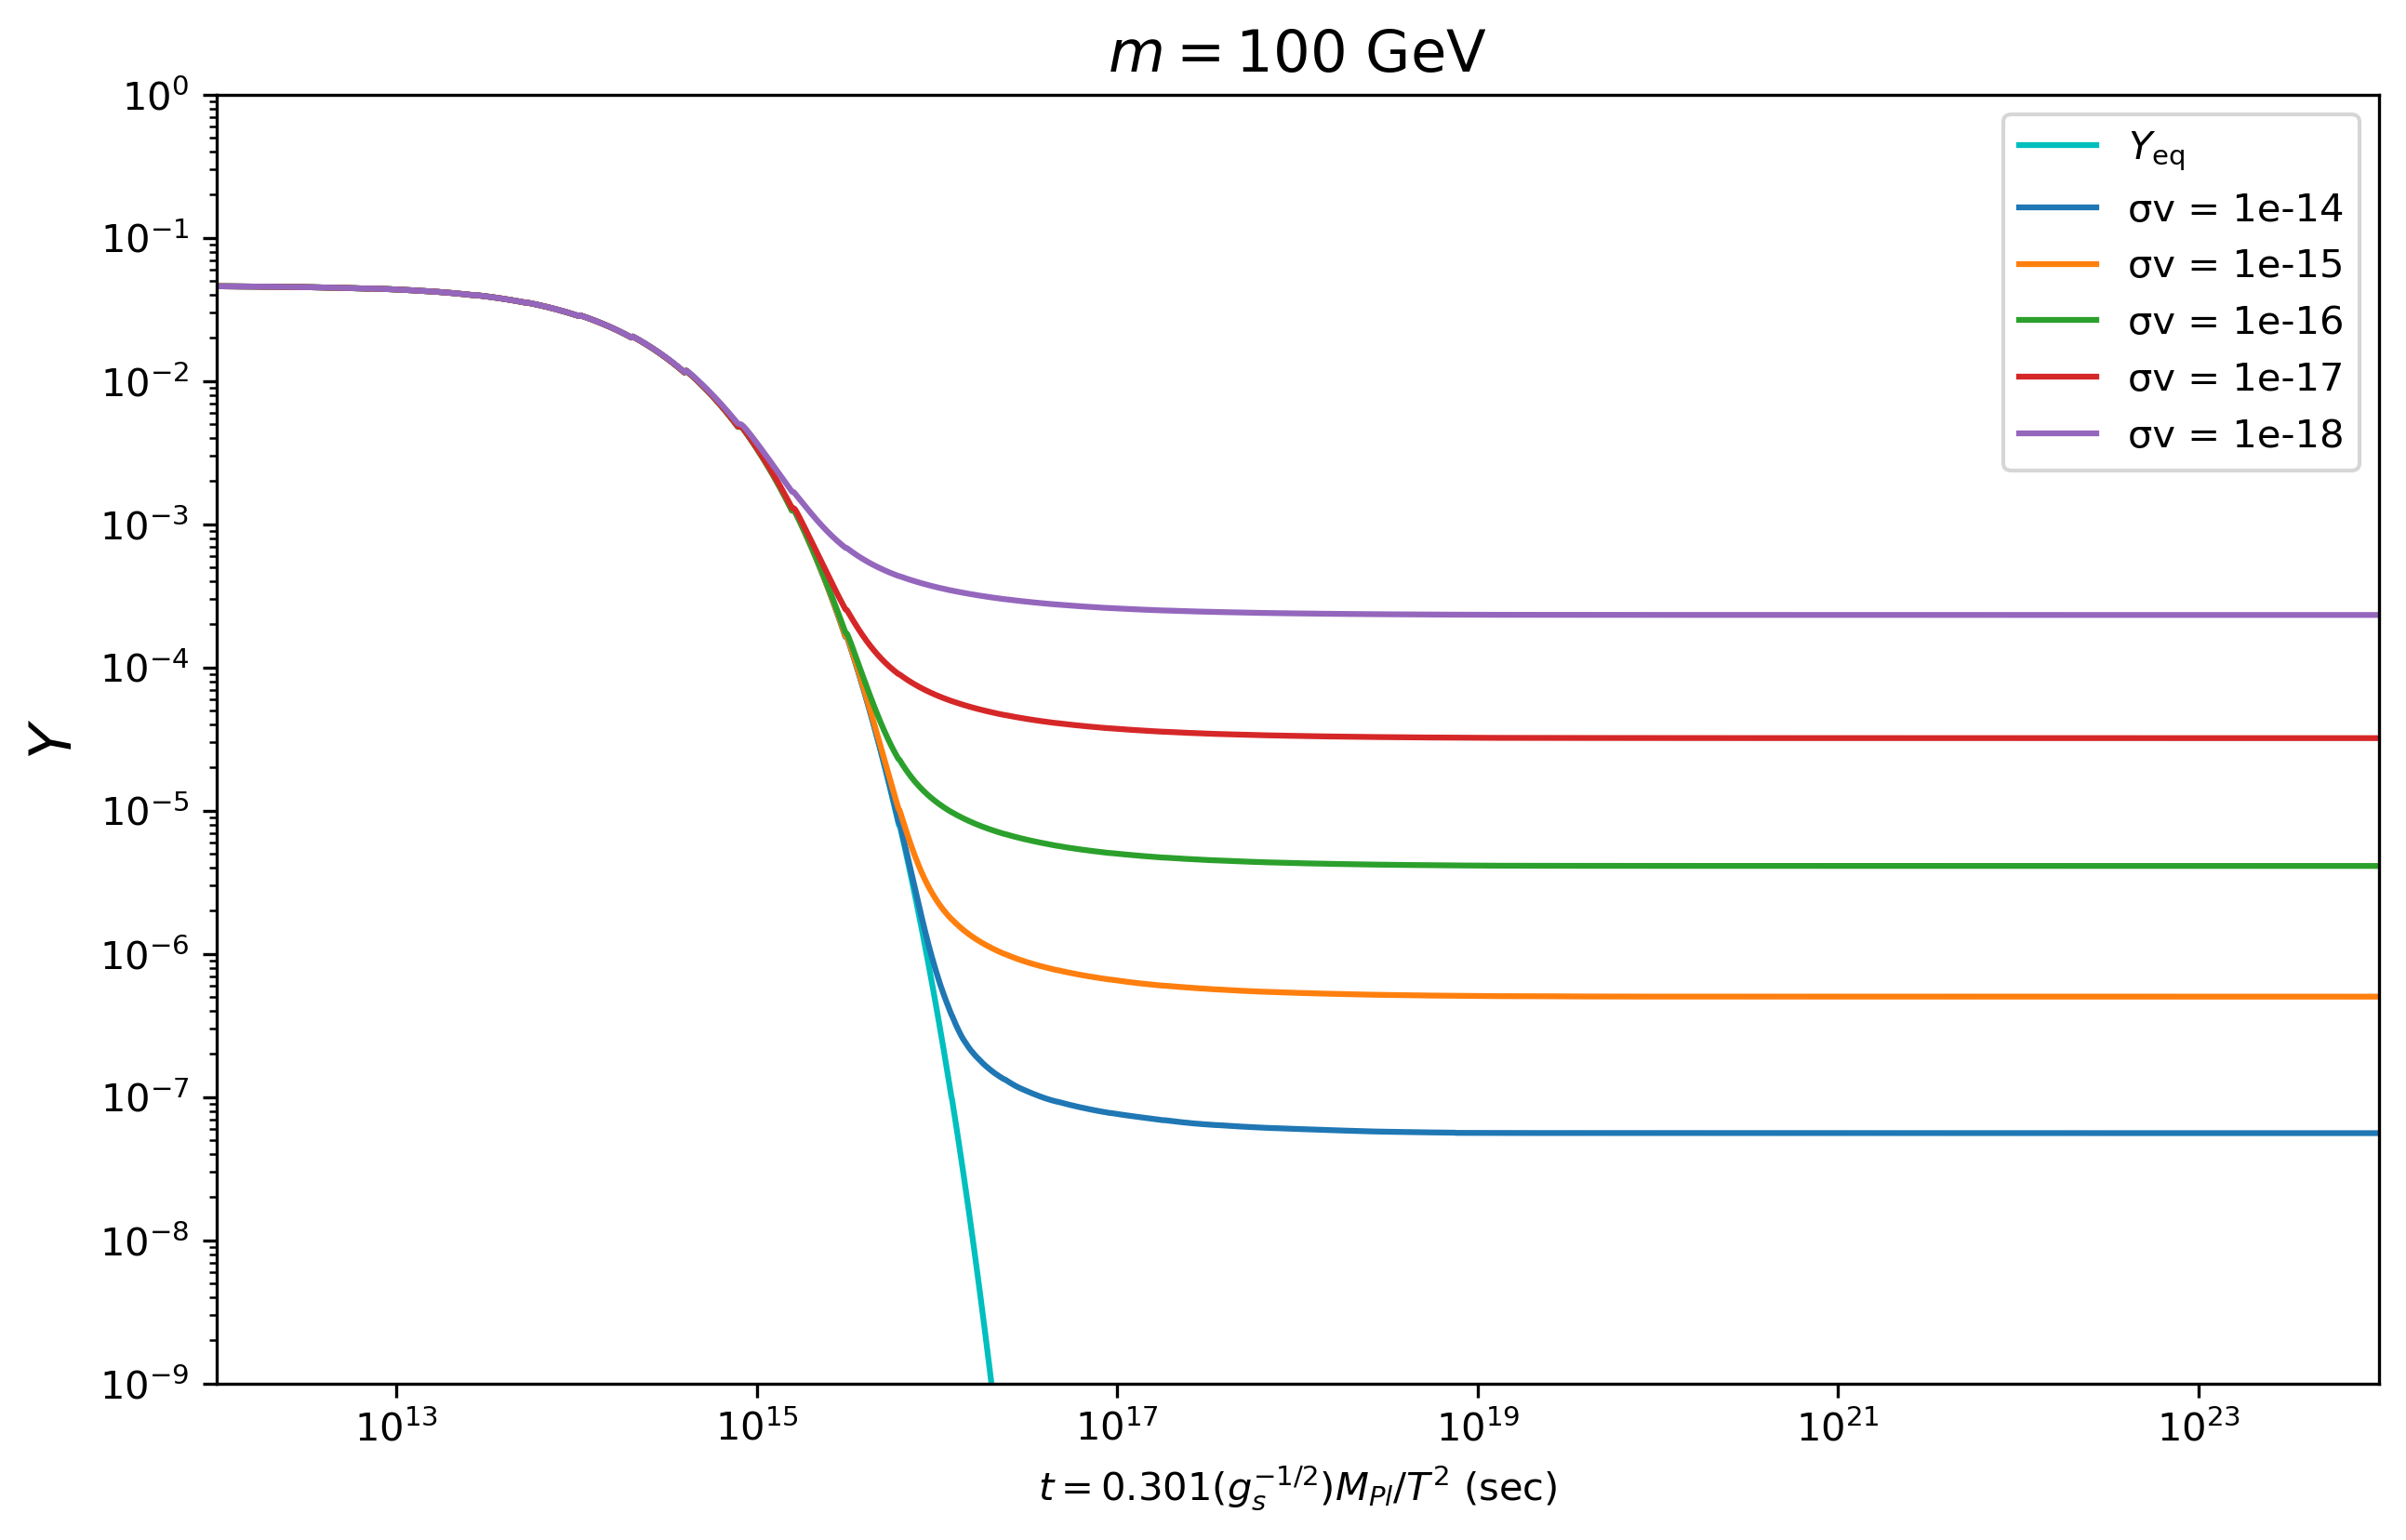

In [172]:
"""
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 6))

x=np.logspace(np.log10(1e-8),np.log10(100000),10000)
xx=np.logspace(np.log10(1e-8),np.log10(1000),10000)
time_axis_xx = time(xx, "Proton")

plt.loglog(time_axis_xx,Y_EQ(xx, 'Proton'),'c',label=r'$Y_{\rm eq}$')

FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    cross_section = particle_cross_sections.get(particle,1)
    mass = particle_mass.get(particle,1)
    
    k=fk(particle)
    Y=integrate.odeint(dYdx,Y_EQ(x[0], particle), x, args=(particle,))
    
    time_axis = time(x, particle)
    
    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y[-1]}')
    
    plt.loglog(time_axis,Y,label=f'σv = {cross_section}')
    
    FreezeOutNumber = np.append(FreezeOutNumber,Y[-1])
    masses = np.append(masses, mass)

print('Frozen-out values: ', FreezeOutNumber)
print(f'Particle masses: {masses}')
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')


plt.ylim(1E-9,1)
plt.xlim(1e12,1e24)
plt.xlabel('$t = 0.301(g_s^{-1/2})M_{Pl}/T^{2}$ (sec)')
plt.ylabel('$Y$', size= 15)
plt.title('$m = 100$ GeV', size = 15)
plt.legend()

plt.savefig('ParticlesTime.png')
"""

[100.10671073 100.10671073 100.10671073 ...  69.76967807  69.76967807
  69.76967807]
